Loading image: C:\Users\ASUS\Documents\stagCNN\tiff_images\ID_0000_AGE_0060_CONTRAST_1_CT.tif

Original Text: Patient ID 5678 CT Normal
Recovered Text: Patient ID 5678 CT Normal
PSNR: 69.17753062450419


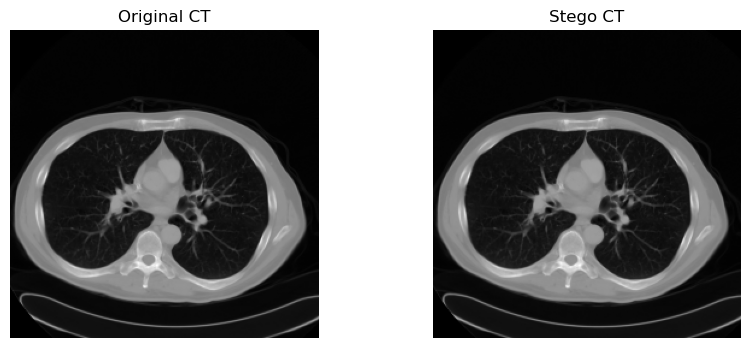

In [20]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from math import log10
import tifffile  # pip install tifffile

# ===========================
# CONFIG
# ===========================
IMAGE_SIZE = 256
MAX_BITS = 1024
LSB_BITS = 1  # minimal for invisibility
SECRET_TEXT = "Patient ID 5678 CT Normal"

# ===========================
# TEXT ↔ BITS
# ===========================
def text_to_bits(text):
    bits = ''.join(format(ord(c), '08b') for c in text)
    bits = bits[:MAX_BITS].ljust(MAX_BITS, '0')
    return np.array([int(b) for b in bits], dtype=np.uint8)

def bits_to_text(bits):
    chars = [bits[i:i+8] for i in range(0, len(bits), 8)]
    out = ""
    for c in chars:
        val = int("".join(map(str, c)), 2)
        if val == 0: break
        out += chr(val)
    return out

# ===========================
# IMAGE METRICS
# ===========================
def mse(a, b):
    return np.mean((a - b) ** 2)

def psnr(a, b):
    m = mse(a, b)
    return 100 if m == 0 else 10 * log10((255*255)/m)

# ===========================
# SAFE IMAGE LOADER (supports 16-bit TIFF)
# ===========================
def load_one_ct_image(folder):
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.tif', '.tiff', '.png', '.jpg'))]
    if not image_files:
        raise RuntimeError(f"No readable images found in {folder}")
    
    path = os.path.join(folder, image_files[0])
    print("Loading image:", path)

    # Try tifffile (best for medical images)
    try:
        img = tifffile.imread(path)
        # If multi-channel, take first channel
        if img.ndim > 2:
            img = img[..., 0]
        # Convert to 8-bit if necessary
        if img.dtype != np.uint8:
            img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
        # Resize
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        return img
    except Exception as e:
        print("tifffile failed:", e)

    # Fallback to PIL
    try:
        pil_img = Image.open(path)
        pil_img = pil_img.convert("L")
        pil_img = pil_img.resize((IMAGE_SIZE, IMAGE_SIZE))
        return np.array(pil_img)
    except Exception as e:
        raise RuntimeError(f"Could not read image {path}: {e}")

# ===========================
# CNN-LIKE MASK (EDGE DETECTION)
# ===========================
def make_edge_mask(image):
    edges = cv2.Laplacian(image, cv2.CV_64F)
    edges = np.abs(edges)
    mask = (edges > np.percentile(edges, 75)).astype(np.uint8)
    coords = np.column_stack(np.where(mask == 1))
    return coords

# ===========================
# LSB EMBEDDING / EXTRACTION
# ===========================
def embed_lsb(image, bits, coords):
    stego = image.copy().astype(np.uint8)  # ensure uint8
    for i, bit in enumerate(bits):
        if i >= len(coords): 
            break
        x, y = coords[i]
        stego[x, y] = np.uint8((int(stego[x, y]) & 0xFE) | int(bit))  # safe uint8 operation
    return stego

def extract_lsb(image, coords, length):
    bits = []
    for i in range(length):
        x, y = coords[i]
        bits.append(image[x, y] & 1)
    return np.array(bits, dtype=np.uint8)

# ===========================
# MAIN
# ===========================
if __name__ == "__main__":
    # Set CT images folder (change path if needed)
    ct_dir = os.path.join(os.getcwd(), "tiff_images")

    cover = load_one_ct_image(ct_dir)
    coords = make_edge_mask(cover)

    bits = text_to_bits(SECRET_TEXT)
    stego = embed_lsb(cover, bits, coords)

    recovered_bits = extract_lsb(stego, coords, len(bits))
    recovered_text = bits_to_text(recovered_bits)

    print("\nOriginal Text:", SECRET_TEXT)
    print("Recovered Text:", recovered_text)
    print("PSNR:", psnr(cover, stego))

    # Display side by side
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(cover, cmap="gray")
    plt.title("Original CT")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(stego, cmap="gray")
    plt.title("Stego CT")
    plt.axis("off")
    plt.show()
